<a href="https://colab.research.google.com/github/fmathews11/Loan_Text/blob/main/Loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd,numpy as np, seaborn as sns,re,random,matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/fmathews11/Loan_Text/main/loans.csv',low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38980 entries, 0 to 38979
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   38980 non-null  object
 1   LOAN_AMNT            38980 non-null  object
 2   TERM                 38980 non-null  object
 3   INSTALLMENT          38980 non-null  object
 4   GRADE                38980 non-null  object
 5   SUB_GRADE            38980 non-null  object
 6   EMP_LENGTH           38980 non-null  object
 7   HOME_OWNERSHIP       38980 non-null  object
 8   ANNUAL_INC           38980 non-null  object
 9   VERIFICATION_STATUS  38980 non-null  object
 10  ISSUE_D              38980 non-null  object
 11  PYMNT_PLAN           38980 non-null  object
 12  desc                 26995 non-null  object
 13  PURPOSE              38980 non-null  object
 14  ADDR_STATE           38980 non-null  object
 15  DTI                  38980 non-null  object
 16  DELI

In [ ]:
df.describe()

,BAD_LOAN
count,38980.000000
mean,0.159159
std,0.365829
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
df2 = df[df.desc.notnull()][['desc','BAD_LOAN']]
df2

,desc,BAD_LOAN
0,Borrower added on 12/22/11 > I need to upgra...,0
1,Borrower added on 12/22/11 > I plan to use t...,1
3,Borrower added on 12/21/11 > to pay for prop...,0
5,Borrower added on 12/16/11 > Downpayment for...,0
6,Borrower added on 12/21/11 > I own a small h...,1
...,...,...
38975,I am getting married on July 28 and will need ...,0
38976,I would like to buy some new furniture in my a...,0
38977,"I need to pay $2,100 for fixing my Volvo :) A...",0
38978,"Hi, I'm buying a used car. Anybody on faceb...",0


In [ ]:
stop_words = set(stopwords.words('english'))

def clean_descriptions(text_string):
  text_string = text_string.upper()
  text_string = text_string.replace("<BR/>","")
  text_string = text_string.replace("<BR>","")
  text_string = text_string.replace("BORROWER ADDED ON","")
  text_sring =  text_string.replace("ADDED ON","")
  text_string = text_string.replace(">","")
  text_string = text_string.strip()
  chars_to_remove = [")","(",".","|","[","]","{","}","'","-",","]
  rx = '[' + re.escape(''.join(chars_to_remove)) + ']' 
  text_string = re.sub(rx, '', text_string)
  text_string = text_string.split()
  for idx,i in enumerate(text_string):
    if len(i) >= 6:
      if i[2] == "/" and i[5]== "/":
        text_string.pop(idx)
  text_string = ' '.join(text_string)
  tokenized = word_tokenize(text_string)
  final = []
  [final.append(i) for i in tokenized if i.isalpha() and i.lower() not in stop_words]
  text_string = " ".join(final)
  return text_string

In [ ]:
df2['desc_clean'] = df2['desc'].map(clean_descriptions)
df2.sample(10)

,desc,BAD_LOAN,desc_clean
21998,Borrower added on 10/01/10 > I have credit c...,0,CREDIT CARD DEBTS ALSO BALLOON PAYMENT MORTGAG...
20347,Borrower added on 11/18/10 > the loan is goi...,0,LOAN GOING PAY SMALL PAYMENT CAR FIX IM GOOD B...
7055,Borrower added on 09/01/11 > I plan to use m...,0,PLAN USE MONEY CONSOLIDATE DEPT REST CAR REPAI...
33167,To pay contractors engaged to remodel.,1,PAY CONTRACTORS ENGAGED REMODEL
16520,Borrower added on 02/25/11 > I have been a p...,0,PRIVATE PIANO TEACHER YEARS DREAM RUN SUMMER P...
33117,This loan request is to supplement our cash fl...,0,LOAN REQUEST SUPPLEMENT CASH FLOW NURSERY SCHO...
13591,Borrower added on 05/05/11 > Using this loan...,0,USING LOAN PAYOFF HIGH INTEREST CREDIT CARD CR...
32571,I am looking to Put all my small debts onto o...,0,LOOKING PUT SMALL DEBTS ONTO ONE MAKE PAYING O...
16161,Borrower added on 03/08/11 > I am currently ...,0,CURRENTLY SAVING WEDDING COUPLED HIGH INTEREST...
14725,Borrower added on 04/11/11 > The funds will ...,1,FUNDS USED PAY CREDIT CARDS EMPLOYED YEARS COM...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


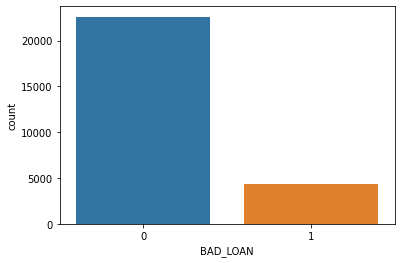

In [ ]:
sns.countplot(df2.BAD_LOAN);

In [ ]:
pd.Series(' '.join(df2[df2.BAD_LOAN == 1]['desc_clean']).split()).value_counts().to_frame("word_count").head(25)

,word_count
LOAN,3916
CREDIT,3550
PAY,2908
DEBT,1983
YEARS,1620
CARDS,1438
TIME,1401
WOULD,1365
PAYMENT,1337
CARD,1255


In [ ]:
pd.Series(' '.join(df2[df2.BAD_LOAN == 0]['desc_clean']).split()).value_counts().to_frame("word_count").head(25)

,word_count
LOAN,21903
CREDIT,21222
PAY,15576
DEBT,11970
YEARS,9041
CARD,8999
INTEREST,7942
CARDS,7695
PAYMENT,7398
WOULD,6426


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


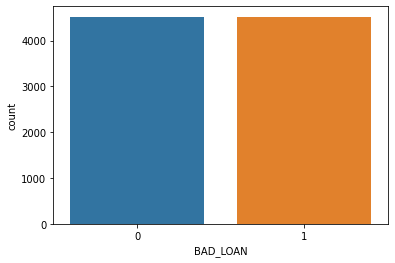

In [ ]:
X = df2.desc_clean
y = df2.BAD_LOAN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42,stratify = y)
vect = TfidfVectorizer(analyzer = 'word')
X_train_transformed = vect.fit_transform(X_train)
X_test_transformed = vect.transform(X_test)
oversample = SMOTE()
X_train_transformed, y_train = oversample.fit_resample(X_train_transformed, y_train)
sns.countplot(y_train)

In [ ]:
clf = LinearSVC(C = 100,max_iter = 10000)
score = cross_val_score(clf,X_train_transformed,y_train,cv =10)
clf.fit(X_train_transformed,y_train)
print(score)
print(accuracy_score(y_test,clf.predict(X_test_transformed)))

KeyboardInterrupt: ignored

In [ ]:
eval_dict = {key:[] for key in ("trees",'train_accuracy','test_accuracy')}
for i in tqdm(range(50,2000,50)):
  clf = RandomForestClassifier(n_estimators = 500,n_jobs = -1,max_samples = 0.05)
  clf.fit(X_train_transformed,y_train)
  eval_dict['trees'].append(i)
  eval_dict['train_accuracy'].append(accuracy_score(y_train,clf.predict(X_train_transformed)))
  eval_dict['test_accuracy'].append(accuracy_score(y_test,clf.predict(X_test_transformed)))
pd.DataFrame.from_dict(eval_dict)

100%|██████████| 39/39 [04:46<00:00,  7.35s/it]


,trees,train_accuracy,test_accuracy
0,50,0.823601,0.689155
1,100,0.822716,0.686284
2,150,0.821831,0.681052
3,200,0.820947,0.687720
4,250,0.816633,0.683645
5,300,0.824818,0.689711
6,350,0.818956,0.683738
7,400,0.822274,0.682395
8,450,0.821500,0.685266
9,500,0.820283,0.684988
